Konusu: Instruction finetuning

https://huggingface.co/ytu-ce-cosmos/turkish-gpt2-large
https://huggingface.co/asafaya/kanarya-750m
modellerini aşağıdaki 3 instraction finetuning veri kümesini kullanarak uyarlayınız.
V1 https://docs.google.com/spreadsheets/d/1NCMx8QCK4qJzMhFAwMwl9dIH88fyYYvr/edit?usp=drive_link&ouid=103534328876075299488&rtpof=true&sd=true

V2 https://huggingface.co/datasets/merve/turkish_instructions

V3 V1+V2

Uyarlama için NEFtune yöntemini kullanınız.
Dokümantasyon: https://huggingface.co/docs/trl/sft_trainer

Uyarlanmış 6 modeli bu veri kümelerinde yer almayan yeni 50 soru cevap ile karşılaştırınız.

# Pre-Requirements

In [ ]:
from IPython.display import clear_output

# Requirements

In [ ]:
!pip install datasets
!git lfs install
!pip install trl
!pip install pytorch
!pip install transformers
!pip install bitsandbytes # for bnb error
!pip install plotly_express
clear_output()

In [ ]:
!git clone https://huggingface.co/datasets/merve/turkish_instructions

Cloning into 'turkish_instructions'...
remote: Enumerating objects: 8, done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 8 (from 1)
Unpacking objects: 100% (8/8), 1.02 KiB | 520.00 KiB/s, done.


# Import

In [ ]:
import pandas as pd
import torch
import warnings
import nltk
import matplotlib.pyplot as plt
import plotly_express as px
import seaborn as sns
warnings.filterwarnings('ignore')
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# First Look

In [ ]:
df1 = pd.read_excel('/content/drive/MyDrive/soru_cevap.xlsx',  header=0)
df1.to_csv('/content/drive/MyDrive/df1.csv', encoding='utf-8', index=False)

In [ ]:
df2 = pd.read_csv('/content/turkish_instructions/instructions.csv', encoding='utf-8')

## First data

In [ ]:
df1

,soru,insan cevabı,makine cevabı,tercih
0,Boğaz köprüsünün sudan yüksekliği kaç metredir?,Boğaz köprüsü denizden 64 metre yüksekliğe sah...,64 metre,3
1,Türkiye'de en yüksek puanla öğrenci kabul eden...,Türkiye'de en yüksek puanla öğrenci kabul eden...,Orta Doğu Teknik Üniversitesi (ODTÜ),1
2,YYTÜ kaç kampüse sahiptir?,Yıldız Teknik Üniversitesi'nin iki adet kampüs...,"Yıldız Teknik Üniversitesi (YTÜ), İstanbul'da ...",2
3,Paris'in en ünlü yapısı nedir?,Paris denince akıllara ilk olarak Eyfel Kulesi...,Eyfel Kulesi,3
4,Uzaya insanlı ilk uçuş ne zaman yapıldı?,Uzaya insanlı ilk uçş 1961 yılında yapılmştır.,12 Nisan 1961,3
...,...,...,...,...
16725,Bir devlet kendini savunmak için nükleer silah...,Bence hiç bit zaman hiç kimsenin nükleer silah...,Uluslararası hukuk ve uluslararası anlaşmalar ...,3
16726,Covid dönemi yașamasaydık neler değişirdi ?,Covid dönemi dünyada bir çok şeyini hızlı bir ...,"Covid-19 salgını olmasaydı, dünya genelinde bi...",3
16727,Para yerine takas yöntemi kullanırsak neler de...,"Eğer para yerine takas yöntemini kullanırsak, ...",Para yerine takas yöntemi kullanılması durumun...,3
16728,Para yerine tüm dünyada altın kullanırırsa nel...,Tüm dünyada para yerine altın kullanmak geliş...,"Eğer tüm dünyada para yerine altın kullanılsa,...",3


In [ ]:
df1.columns

Index(['soru', 'insan cevabı', 'makine cevabı', 'tercih'], dtype='object')

In [ ]:
df1.columns = ['input', 'instructions', 'response', 'choice']

In [ ]:
df1.drop(['choice'], axis=1, inplace=True)

In [ ]:
df1

,input,instructions,response
0,Boğaz köprüsünün sudan yüksekliği kaç metredir?,Boğaz köprüsü denizden 64 metre yüksekliğe sah...,64 metre
1,Türkiye'de en yüksek puanla öğrenci kabul eden...,Türkiye'de en yüksek puanla öğrenci kabul eden...,Orta Doğu Teknik Üniversitesi (ODTÜ)
2,YYTÜ kaç kampüse sahiptir?,Yıldız Teknik Üniversitesi'nin iki adet kampüs...,"Yıldız Teknik Üniversitesi (YTÜ), İstanbul'da ..."
3,Paris'in en ünlü yapısı nedir?,Paris denince akıllara ilk olarak Eyfel Kulesi...,Eyfel Kulesi
4,Uzaya insanlı ilk uçuş ne zaman yapıldı?,Uzaya insanlı ilk uçş 1961 yılında yapılmştır.,12 Nisan 1961
...,...,...,...
16725,Bir devlet kendini savunmak için nükleer silah...,Bence hiç bit zaman hiç kimsenin nükleer silah...,Uluslararası hukuk ve uluslararası anlaşmalar ...
16726,Covid dönemi yașamasaydık neler değişirdi ?,Covid dönemi dünyada bir çok şeyini hızlı bir ...,"Covid-19 salgını olmasaydı, dünya genelinde bi..."
16727,Para yerine takas yöntemi kullanırsak neler de...,"Eğer para yerine takas yöntemini kullanırsak, ...",Para yerine takas yöntemi kullanılması durumun...
16728,Para yerine tüm dünyada altın kullanırırsa nel...,Tüm dünyada para yerine altın kullanmak geliş...,"Eğer tüm dünyada para yerine altın kullanılsa,..."


## Second data

In [ ]:
df2

,Unnamed: 0,talimat,giriş,çıktı
0,0,Aşağıdaki bağlamda orijinal bir şey söyleyin:...,NaN,Ekibe katkıda bulunmaya başlamak ve bu alanda...
1,1,Aşağıdaki makale için bir başlık önerin: Bu m...,NaN,"""Dijital İletişimin Gücü: İnternet İş Ortamın..."
2,2,Şu konuyla ilgili 5 anahtar kelimeden oluşan ...,NaN,1. Karbon emisyonları 2. Yenilenebilir enerji...
3,3,Bu cümleyi pasiften aktife değiştirin: Yeni p...,NaN,Belediye başkanı yeni politikayı açıkladı.
4,4,Aşağıdaki fenomeni tanımlayan üç bilimsel teri...,NaN,"Yerçekimi kuvveti, Newton'un evrensel çekim y..."
...,...,...,...,...
51558,51558,Finansal okuryazarlık konusunda eğitim veren ...,NaN,"Bu mobil uygulama, kullanıcılara finansal okur..."
51559,51559,Yavaş bir bilgisayarı düzeltmek için bir yönt...,NaN,Yavaş bir bilgisayar inanılmaz derecede sinir ...
51560,51560,Bir görevin başarısını değerlendirmek için bi...,Buluta geçiş.,"Buluta başarılı bir geçiş, buluta taşınan uygu..."
51561,51561,"Bu cümleyi yeniden yazın: ""Hedefe ulaşmanın en...",NaN,"Uçağa binmek, varış noktasına ulaşmanın en hı..."


In [ ]:
df2.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
df2.columns = ['instructions', 'input', 'response']

In [ ]:
df2 = df2[['input', 'instructions', 'response']]

In [ ]:
df2

,input,instructions,response
0,NaN,Aşağıdaki bağlamda orijinal bir şey söyleyin:...,Ekibe katkıda bulunmaya başlamak ve bu alanda...
1,NaN,Aşağıdaki makale için bir başlık önerin: Bu m...,"""Dijital İletişimin Gücü: İnternet İş Ortamın..."
2,NaN,Şu konuyla ilgili 5 anahtar kelimeden oluşan ...,1. Karbon emisyonları 2. Yenilenebilir enerji...
3,NaN,Bu cümleyi pasiften aktife değiştirin: Yeni p...,Belediye başkanı yeni politikayı açıkladı.
4,NaN,Aşağıdaki fenomeni tanımlayan üç bilimsel teri...,"Yerçekimi kuvveti, Newton'un evrensel çekim y..."
...,...,...,...
51558,NaN,Finansal okuryazarlık konusunda eğitim veren ...,"Bu mobil uygulama, kullanıcılara finansal okur..."
51559,NaN,Yavaş bir bilgisayarı düzeltmek için bir yönt...,Yavaş bir bilgisayar inanılmaz derecede sinir ...
51560,Buluta geçiş.,Bir görevin başarısını değerlendirmek için bi...,"Buluta başarılı bir geçiş, buluta taşınan uygu..."
51561,NaN,"Bu cümleyi yeniden yazın: ""Hedefe ulaşmanın en...","Uçağa binmek, varış noktasına ulaşmanın en hı..."


## Merging two data

In [ ]:
# Merg two csv file
data = pd.concat([df1, df2], ignore_index=True)

In [ ]:
data

,input,instructions,response
0,Boğaz köprüsünün sudan yüksekliği kaç metredir?,Boğaz köprüsü denizden 64 metre yüksekliğe sah...,64 metre
1,Türkiye'de en yüksek puanla öğrenci kabul eden...,Türkiye'de en yüksek puanla öğrenci kabul eden...,Orta Doğu Teknik Üniversitesi (ODTÜ)
2,YYTÜ kaç kampüse sahiptir?,Yıldız Teknik Üniversitesi'nin iki adet kampüs...,"Yıldız Teknik Üniversitesi (YTÜ), İstanbul'da ..."
3,Paris'in en ünlü yapısı nedir?,Paris denince akıllara ilk olarak Eyfel Kulesi...,Eyfel Kulesi
4,Uzaya insanlı ilk uçuş ne zaman yapıldı?,Uzaya insanlı ilk uçş 1961 yılında yapılmştır.,12 Nisan 1961
...,...,...,...
68288,NaN,Finansal okuryazarlık konusunda eğitim veren ...,"Bu mobil uygulama, kullanıcılara finansal okur..."
68289,NaN,Yavaş bir bilgisayarı düzeltmek için bir yönt...,Yavaş bir bilgisayar inanılmaz derecede sinir ...
68290,Buluta geçiş.,Bir görevin başarısını değerlendirmek için bi...,"Buluta başarılı bir geçiş, buluta taşınan uygu..."
68291,NaN,"Bu cümleyi yeniden yazın: ""Hedefe ulaşmanın en...","Uçağa binmek, varış noktasına ulaşmanın en hı..."


In [ ]:
data.columns

Index(['input', 'instructions', 'response'], dtype='object')

In [ ]:
def check_data(data):
  isna_count = data.isna().sum()
  isna_percentage = data.isna().sum() / len(data)
  isna_percentage = isna_percentage.apply(lambda x: f"{x:.1%}")
  duplicate_data = print("Duplicated Data: ", data.duplicated().sum())
  result = pd.concat([isna_count, isna_percentage], axis=1)
  result.columns = ['Total Null Data', 'Total Null Percentage']
  return result
check_data(data)

Duplicated Data:  45


,Total Null Data,Total Null Percentage
input,32475,47.6%
instructions,0,0.0%
response,0,0.0%


In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
data.to_csv('cleaned-dataset.csv', index=False)
print("Saved !")

Saved !


# NEFTune

## V1 Data NEFTune

### With GPT-2 Large 750M

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer_gpt = AutoTokenizer.from_pretrained("ytu-ce-cosmos/turkish-gpt2-large")
model_gpt = AutoModelForCausalLM.from_pretrained("ytu-ce-cosmos/turkish-gpt2-large")
clear_output()

In [ ]:
v3_prompt = """Aşağıda, daha fazla bağlam sağlayan bir girdiyle eşleştirilmiş, bir görevi açıklayan bir talimat bulunmaktadır. İsteği uygun şekilde tamamlayan bir yanıt yazın.

### Input:
{}


### Instructions:
{}


### Response:
{}"""

In [ ]:
EOS_TOKEN = tokenizer_gpt.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    inputs       = examples["input"]
    instructions = examples['instructions']
    outputs      = examples["response"]
    texts = []
    for input, instructions, output in zip(inputs, instructions, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = v3_prompt.format(input, instructions, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import Dataset

dataset_v1 = Dataset.from_pandas(df1)
dataset_v1 = dataset_v1.map(formatting_prompts_func, batched=True)

Map:   0%|          | 0/16730 [00:00<?, ? examples/s]

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.564 GB.
0.0 GB of memory reserved.


In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer_1 = SFTTrainer(
    model=model_gpt,
    train_dataset=dataset_v1,
    dataset_text_field="text",
    max_seq_length=2048,
    neftune_noise_alpha=5,
    packing=False,
    args = TrainingArguments(
        per_device_train_batch_size = 1, #  batch size
        gradient_accumulation_steps = 2, #  gradient accumulation steps
        warmup_steps = 5,
        max_steps = 80,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Map:   0%|          | 0/16730 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer_stats = trainer_1.train()

Step,Training Loss
1,3.795300
2,2.948900
3,2.343000
4,2.040000
5,1.672000
6,2.008000
7,2.282600
8,1.836000
9,2.401300
10,2.548200


In [ ]:
model_gpt.save_pretrained("fine_tuned_gpt_v1")
tokenizer_gpt.save_pretrained("fine_tuned_gpt_v1")

('fine_tuned_gpt_v1/tokenizer_config.json',
 'fine_tuned_gpt_v1/special_tokens_map.json',
 'fine_tuned_gpt_v1/vocab.json',
 'fine_tuned_gpt_v1/merges.txt',
 'fine_tuned_gpt_v1/added_tokens.json',
 'fine_tuned_gpt_v1/tokenizer.json')

In [ ]:
inputs = tokenizer_gpt(
[
    v3_prompt.format(
        "1, 1, 2, 3, 5, 8", # input
        "Fibonnaci dizisine devam edin.", # instruction
        "", # response
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer_gpt)
_ = model_gpt.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

Aşağıda, daha fazla bağlam sağlayan bir girdiyle eşleştirilmiş, bir görevi açıklayan bir talimat bulunmaktadır. İsteği uygun şekilde tamamlayan bir yanıt yazın.

### Input:
1, 1, 2, 3, 5, 8


### Instructions:
Fibonnaci dizisine devam edin.


### Response:
Fibrit dizisindeki devam eden dizilerden biri olan 1, 2, 3, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 20, 21, 23, 24, 25, 26, 28, 29, 29, 30, 31, 32, 33, 34, 35, 35, 35, 36, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_train = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
train_percentage = round(used_memory_for_train/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_train} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {train_percentage} %.")

24.7243 seconds used for training.
0.41 minutes used for training.
Peak reserved memory = 14.027 GB.
Peak reserved memory for training = 14.027 GB.
Peak reserved memory % of max memory = 35.454 %.
Peak reserved memory for training % of max memory = 35.454 %.


### With Kanarya-750M

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.564 GB.
14.027 GB of memory reserved.


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer_kanarya = AutoTokenizer.from_pretrained("asafaya/kanarya-750m")
model_kanarya = AutoModelForCausalLM.from_pretrained("asafaya/kanarya-750m")

tokenizer_config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/589k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/370k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.52M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/161 [00:00<?, ?B/s]

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer_2 = SFTTrainer(
    model=model_kanarya,
    train_dataset=dataset_v1,
    dataset_text_field="text",
    max_seq_length=2048,
    neftune_noise_alpha=5,
    packing=False,
    args = TrainingArguments(
        per_device_train_batch_size = 2, #  batch size
        gradient_accumulation_steps = 3, #  gradient accumulation steps
        warmup_steps = 5,
        max_steps = 200,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.1,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Map:   0%|          | 0/16730 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer_stats_2 = trainer_2.train()

Step,Training Loss
1,3.027400
2,3.012100
3,6.315700
4,10.575900
5,10.903800
6,12.845000
7,15.561800
8,17.497500
9,16.549300
10,18.008100


In [ ]:
model_kanarya.save_pretrained("fine_tuned_kanarya_v1")
tokenizer_kanarya.save_pretrained("fine_tuned_kanarya_v1")

('fine_tuned_kanarya_v1/tokenizer_config.json',
 'fine_tuned_kanarya_v1/special_tokens_map.json',
 'fine_tuned_kanarya_v1/vocab.json',
 'fine_tuned_kanarya_v1/merges.txt',
 'fine_tuned_kanarya_v1/added_tokens.json',
 'fine_tuned_kanarya_v1/tokenizer.json')

In [ ]:
inputs = tokenizer_kanarya(
[
    v3_prompt.format(
        "1, 1, 2, 3, 5, 8", # input
        "Fibonnaci dizisine devam edin.", # instruction
        "", # response
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer_kanarya)
_ = model_kanarya.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> Aşağıda, daha fazla bağlam sağlayan bir girdiyle eşleştirilmiş, bir görevi açıklayan bir talimat bulunmaktadır. İsteği uygun şekilde tamamlayan bir yanıt yazın.

### Input:
1, 1, 2, 3, 5, 8


### Instructions:
Fibonnaci dizisine devam edin.


### Response:
## Instructions:
Her, saat kullanılır.
5.





Yüzlar,?





Put:



>|endoftext|endtext|><|end>5-.
Trafik,:





###### Response: Güneş ve yanıt nedir.
#### Instoftext|endoftext|endoftext|end>

# Inp' 21":


#### Instructions:


###


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_train = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
train_percentage = round(used_memory_for_train/max_memory*100, 3)
print(f"{trainer_stats_2.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats_2.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_train} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {train_percentage} %.")

52.5291 seconds used for training.
0.88 minutes used for training.
Peak reserved memory = 25.074 GB.
Peak reserved memory for training = 11.047 GB.
Peak reserved memory % of max memory = 63.376 %.
Peak reserved memory for training % of max memory = 27.922 %.


## V2 Data NEFTune

### With GPT-2 Large 750M

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer_gpt = AutoTokenizer.from_pretrained("ytu-ce-cosmos/turkish-gpt2-large")
model_gpt = AutoModelForCausalLM.from_pretrained("ytu-ce-cosmos/turkish-gpt2-large")
clear_output()

In [ ]:
v3_prompt = """Aşağıda, daha fazla bağlam sağlayan bir girdiyle eşleştirilmiş, bir görevi açıklayan bir talimat bulunmaktadır. İsteği uygun şekilde tamamlayan bir yanıt yazın.

### Input:
{}


### Instructions:
{}


### Response:
{}"""

In [ ]:
EOS_TOKEN = tokenizer_gpt.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    inputs       = examples["input"]
    instructions = examples['instructions']
    outputs      = examples["response"]
    texts = []
    for input, instructions, output in zip(inputs, instructions, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = v3_prompt.format(input, instructions, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import Dataset

dataset_v2 = Dataset.from_pandas(df2[:40000])
dataset_v2 = dataset_v2.map(formatting_prompts_func, batched=True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.564 GB.
25.074 GB of memory reserved.


In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer_3 = SFTTrainer(
    model=model_gpt,
    train_dataset=dataset_v2,
    dataset_text_field="text",
    max_seq_length=2048,
    neftune_noise_alpha=5,
    packing=False,
    args = TrainingArguments(
        per_device_train_batch_size = 1, #  batch size
        gradient_accumulation_steps = 2, #  gradient accumulation steps
        warmup_steps = 5,
        max_steps = 80,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer_stats = trainer_3.train()

Step,Training Loss
1,4.016900
2,3.727800
3,2.337700
4,2.065400
5,2.157200
6,1.962100
7,2.011400
8,2.700500
9,2.944200
10,2.250000


In [ ]:
model_gpt.save_pretrained("fine_tuned_gpt_v2")
tokenizer_gpt.save_pretrained("fine_tuned_gpt_v2")

('fine_tuned_gpt_v2/tokenizer_config.json',
 'fine_tuned_gpt_v2/special_tokens_map.json',
 'fine_tuned_gpt_v2/vocab.json',
 'fine_tuned_gpt_v2/merges.txt',
 'fine_tuned_gpt_v2/added_tokens.json',
 'fine_tuned_gpt_v2/tokenizer.json')

In [ ]:
inputs = tokenizer_gpt(
[
    v3_prompt.format(
        "1, 1, 2, 3, 5, 8", # input
        "Fibonnaci dizisine devam edin.", # instruction
        "", # response
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer_gpt)
_ = model_gpt.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

Aşağıda, daha fazla bağlam sağlayan bir girdiyle eşleştirilmiş, bir görevi açıklayan bir talimat bulunmaktadır. İsteği uygun şekilde tamamlayan bir yanıt yazın.

### Input:
1, 1, 2, 3, 5, 8


### Instructions:
Fibonnaci dizisine devam edin.


### Response:
 Fotosentez, bir organizma tarafından üretilirken, bir organizma tarafından üretilmez. Fotosentez, bir organizma tarafından üretilirken, bir organizma tarafından üretilmez. Fotosentez, bir organizma tarafından üretilirken, bir organizma tarafından üretilmez. Fotosentez, bir organizma tarafından üretilirken, bir organizma tarafından üretilmez. Fotosentez, bir organizma tarafından üretilirken, bir organizma tarafından üretilmez. Fotosentez, bir organizma tarafından üretilirken, bir organizma tarafından üretilmez. Fotosentez, bir organizma tarafından üretilirken, bir organizma tarafından üretilmez. Fotos


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_train = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
train_percentage = round(used_memory_for_train/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_train} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {train_percentage} %.")

24.0864 seconds used for training.
0.4 minutes used for training.
Peak reserved memory = 25.074 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 63.376 %.
Peak reserved memory for training % of max memory = 0.0 %.


### With Kanarya-750M

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.564 GB.
25.074 GB of memory reserved.


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer_kanarya = AutoTokenizer.from_pretrained("asafaya/kanarya-750m")
model_kanarya = AutoModelForCausalLM.from_pretrained("asafaya/kanarya-750m")

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer_4 = SFTTrainer(
    model=model_kanarya,
    train_dataset=dataset_v2,
    dataset_text_field="text",
    max_seq_length=2048,
    neftune_noise_alpha=5,
    packing=False,
    args = TrainingArguments(
        per_device_train_batch_size = 2, #  batch size
        gradient_accumulation_steps = 3, #  gradient accumulation steps
        warmup_steps = 5,
        max_steps = 200,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.1,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer_stats = trainer_4.train()

Step,Training Loss
1,3.848200
2,3.709200
3,7.081000
4,10.183500
5,10.226900
6,13.826200
7,15.988000
8,18.514000
9,17.218500
10,18.654900


In [ ]:
model_kanarya.save_pretrained("fine_tuned_kanarya_v2")
tokenizer_kanarya.save_pretrained("fine_tuned_kanarya_v2")

('fine_tuned_kanarya_v2/tokenizer_config.json',
 'fine_tuned_kanarya_v2/special_tokens_map.json',
 'fine_tuned_kanarya_v2/vocab.json',
 'fine_tuned_kanarya_v2/merges.txt',
 'fine_tuned_kanarya_v2/added_tokens.json',
 'fine_tuned_kanarya_v2/tokenizer.json')

In [ ]:
inputs = tokenizer_kanarya(
[
    v3_prompt.format(
        "1, 1, 2, 3, 5, 8", # input
        "Fibonnaci dizisine devam edin.", # instruction
        "", # response
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer_kanarya)
_ = model_kanarya.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> Aşağıda, daha fazla bağlam sağlayan bir girdiyle eşleştirilmiş, bir görevi açıklayan bir talimat bulunmaktadır. İsteği uygun şekilde tamamlayan bir yanıt yazın.

### Input:
1, 1, 2, 3, 5, 8


### Instructions:
Fibonnaci dizisine devam edin.


### Response:
 Bu tür ve son ve hakkında daha bir görevi açıklayan iki, bir liste oluşturun ve olarak, zaman ve.<|endoftext|><|><|>1<|endoftext|endoftext|>, bir şekilde tamamlayan bir ve, ve ve, 2.


### Instructions:
None
<|endoftext|endof<|><|endoftext|>4- 9.

########### Instructions:

<|endoftext|>de:

##


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_train = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
train_percentage = round(used_memory_for_train/max_memory*100, 3)
print(f"{trainer_stats_2.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats_2.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_train} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {train_percentage} %.")

52.5291 seconds used for training.
0.88 minutes used for training.
Peak reserved memory = 26.125 GB.
Peak reserved memory for training = 1.051 GB.
Peak reserved memory % of max memory = 66.032 %.
Peak reserved memory for training % of max memory = 2.656 %.


## V3 Data NEFTune

### With GPT-2 Large 750M

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer_gpt = AutoTokenizer.from_pretrained("ytu-ce-cosmos/turkish-gpt2-large")
model_gpt = AutoModelForCausalLM.from_pretrained("ytu-ce-cosmos/turkish-gpt2-large")
clear_output()

In [ ]:
v3_prompt = """Aşağıda, daha fazla bağlam sağlayan bir girdiyle eşleştirilmiş, bir görevi açıklayan bir talimat bulunmaktadır. İsteği uygun şekilde tamamlayan bir yanıt yazın.

### Input:
{}


### Instructions:
{}


### Response:
{}"""

In [ ]:
EOS_TOKEN = tokenizer_gpt.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    inputs       = examples["input"]
    instructions = examples['instructions']
    outputs      = examples["response"]
    texts = []
    for input, instructions, output in zip(inputs, instructions, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = v3_prompt.format(input, instructions, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import Dataset

dataset_v3 = Dataset.from_pandas(data[:40000])
dataset_v3 = dataset_v3.map(formatting_prompts_func, batched=True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.564 GB.
26.125 GB of memory reserved.


In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer_5 = SFTTrainer(
    model=model_gpt,
    train_dataset=dataset_v3,
    dataset_text_field="text",
    max_seq_length=2048,
    neftune_noise_alpha=5,
    packing=False,
    args = TrainingArguments(
        per_device_train_batch_size = 1, #  batch size
        gradient_accumulation_steps = 2, #  gradient accumulation steps
        warmup_steps = 5,
        max_steps = 80,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer_stats = trainer_5.train()

Step,Training Loss
1,3.594800
2,3.258700
3,2.491800
4,1.327800
5,2.538400
6,2.079500
7,2.516100
8,1.646700
9,2.133600
10,3.172900


In [ ]:
model_gpt.save_pretrained("fine_tuned_gpt_v3")
tokenizer_gpt.save_pretrained("fine_tuned_gpt_v3")

('fine_tuned_gpt_v3/tokenizer_config.json',
 'fine_tuned_gpt_v3/special_tokens_map.json',
 'fine_tuned_gpt_v3/vocab.json',
 'fine_tuned_gpt_v3/merges.txt',
 'fine_tuned_gpt_v3/added_tokens.json',
 'fine_tuned_gpt_v3/tokenizer.json')

In [ ]:
inputs = tokenizer_gpt(
[
    v3_prompt.format(
        "1, 1, 2, 3, 5, 8", # input
        "Fibonnaci dizisine devam edin.", # instruction
        "", # response
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer_gpt)
_ = model_gpt.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

Aşağıda, daha fazla bağlam sağlayan bir girdiyle eşleştirilmiş, bir görevi açıklayan bir talimat bulunmaktadır. İsteği uygun şekilde tamamlayan bir yanıt yazın.

### Input:
1, 1, 2, 3, 5, 8


### Instructions:
Fibonnaci dizisine devam edin.


### Response:
Fibonnaci dizisine devam edin.


### Response:
Fibonnaci, Fibonnaci dizisi, Fibonnaci dizisi, Fibonnaci dizisi, Fibonnaci dizisi, Fibonnaci dizisi, Fibonnaci dizisi, Fibonnaci dizisi, Fibonnaci dizisi, Fibonnaci dizisi, Fibonnaci dizisi, Fibonnaci dizisi, Fibonnaci dizisi, Fibonnaci dizisi, Fibonnaci dizisi, Fibonnaci dizisi, Fibonnaci dizisi, Fibonnaci dizisi, Fibon


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_train = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
train_percentage = round(used_memory_for_train/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_train} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {train_percentage} %.")

23.7973 seconds used for training.
0.4 minutes used for training.
Peak reserved memory = 35.197 GB.
Peak reserved memory for training = 9.072 GB.
Peak reserved memory % of max memory = 88.962 %.
Peak reserved memory for training % of max memory = 22.93 %.


### With Kanarya-750M

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.564 GB.
35.197 GB of memory reserved.


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer_kanarya = AutoTokenizer.from_pretrained("asafaya/kanarya-750m")
model_kanarya = AutoModelForCausalLM.from_pretrained("asafaya/kanarya-750m")

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer_6 = SFTTrainer(
    model=model_kanarya,
    train_dataset=dataset_v3,
    dataset_text_field="text",
    max_seq_length=2048,
    neftune_noise_alpha=5,
    packing=False,
    args = TrainingArguments(
        per_device_train_batch_size = 2, #  batch size
        gradient_accumulation_steps = 3, #  gradient accumulation steps
        warmup_steps = 5,
        max_steps = 200,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.1,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer_stats_2 = trainer_6.train()

Step,Training Loss
1,3.330600
2,3.192500
3,7.893100
4,9.112300
5,10.898400
6,12.975300
7,15.094600
8,18.907200
9,21.168600
10,20.461000


In [ ]:
model_kanarya.save_pretrained("fine_tuned_kanarya_v3")
tokenizer_kanarya.save_pretrained("fine_tuned_kanarya_v3")

('fine_tuned_kanarya_v3/tokenizer_config.json',
 'fine_tuned_kanarya_v3/special_tokens_map.json',
 'fine_tuned_kanarya_v3/vocab.json',
 'fine_tuned_kanarya_v3/merges.txt',
 'fine_tuned_kanarya_v3/added_tokens.json',
 'fine_tuned_kanarya_v3/tokenizer.json')

In [ ]:
inputs = tokenizer_kanarya(
[
    v3_prompt.format(
        "1, 1, 2, 3, 5, 8", # input
        "Fibonnaci dizisine devam edin.", # instruction
        "", # response
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer_kanarya)
_ = model_kanarya.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> Aşağıda, daha fazla bağlam sağlayan bir girdiyle eşleştirilmiş, bir görevi açıklayan bir talimat bulunmaktadır. İsteği uygun şekilde tamamlayan bir yanıt yazın.

### Input:
1, 1, 2, 3, 5, 8


### Instructions:
Fibonnaci dizisine devam edin.


### Response:





##### Response:
### Instructions:
None
Noftext|endoftext|>,,,iyle daha fazla bir bir yanıt yazın.

 Uzay.



## Inpendoftext|>oftext|endoftext|endoftext||endoftext|>2.










None:



 İste ve girdiyle uygun şekilde tamamlayan bir bir iş, bir bir, bir biyolojik olduğu bir,,, tür,, ve:


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_train = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
train_percentage = round(used_memory_for_train/max_memory*100, 3)
print(f"{trainer_stats_2.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats_2.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_train} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {train_percentage} %.")

50.0665 seconds used for training.
0.83 minutes used for training.
Peak reserved memory = 39.033 GB.
Peak reserved memory for training = 3.836 GB.
Peak reserved memory % of max memory = 98.658 %.
Peak reserved memory for training % of max memory = 9.696 %.


# Comparing 3 dataset

In [ ]:
model_path_v1 = "/content/fine_tuned_gpt_v1"
model_path_v1 = "/content/fine_tuned_kanarya_v1"
model_path_v2 = "/content/fine_tuned_gpt_v2"
model_path_v2 = "/content/fine_tuned_kanarya_v2"
model_path_v3 = "/content/fine_tuned_gpt_v3"
model_path_v3 = "/content/fine_tuned_kanarya_v3"

# V1 data
fine_tuned_gpt_v1 = AutoModelForCausalLM.from_pretrained(model_path_v1)
fine_tuned_gpt_tokenizer_v1 = AutoTokenizer.from_pretrained(model_path_v1)

fine_tuned_kanarya_v1 = AutoModelForCausalLM.from_pretrained(model_path_v1)
fine_tuned_kanarya_tokenizer_v1 = AutoTokenizer.from_pretrained(model_path_v1)
# V2 data
fine_tuned_gpt_v2 = AutoModelForCausalLM.from_pretrained(model_path_v2)
fine_tuned_gpt_tokenizer_v2 = AutoTokenizer.from_pretrained(model_path_v2)

fine_tuned_kanarya_v2 = AutoModelForCausalLM.from_pretrained(model_path_v2)
fine_tuned_kanarya_tokenizer_v2 = AutoTokenizer.from_pretrained(model_path_v2)
# V3 data
fine_tuned_gpt_v3 = AutoModelForCausalLM.from_pretrained(model_path_v3)
fine_tuned_gpt_tokenizer_v3 = AutoTokenizer.from_pretrained(model_path_v3)

fine_tuned_kanarya_v3 = AutoModelForCausalLM.from_pretrained(model_path_v3)
fine_tuned_kanarya_tokenizer_v3 = AutoTokenizer.from_pretrained(model_path_v3)

In [ ]:
#@title Show 50 random question
"""
Acknowledgement:
                Random 50 question withdrawn from dataset unused part and collected internet.
"""
questions = [
    {
    "instructions": "Bu hayvan listesini en küçüğünden en büyüğüne göre sıralayın.",
    "input": "Tavşan, Fil, Kedi, At",
    "response": ""
    },
    {
    "instructions": "Aşağıdaki isim listesine bakın ve hangilerinin gerçek insanlar olmadığını tespit edin.",
    "input": "Julie Jones, Victor Johnson, Terrence Smith, Michelangelo Turşu, Shana Washington",
    "response": ""
    },
    {
    "instructions": "Aşağıdaki kelimeyi Amerikan İngilizcesinde heceleyin.",
    "input": "gerçekleştirme",
    "response": ""
    },
    {
    "instructions": "Aşağıdaki örneği bir algoritmaya veya buluşsal yönteme ait olarak sınıflandırın.",
    "input": "Bir şirket, çalışanlarının geçen hafta 75 saatten fazla çalıştıkları takdirde izin almalarına izin veren bir kural uyguluyor.",
    "response": ""
    },
    {
    "instructions": "Sağlanan kodu anonim bir işlev olarak yeniden yazın.",
    "input": "function sum(a, b) { a + b döndürür; }",
    "response": ""
    },
    {
    "instructions": "Aşağıdaki cümlenin türünü belirleyiniz. Türü doğrudan çıktılayın.",
    "input": "mağazaya gitti.",
    "response": ""
    },
    {
    "instructions": "Çiçeği bir çiçek türü olarak sınıflandırın.",
    "input": "Yıldız çiçeği",
    "response": ""
    },
    {
    "instructions": "İsim yerine zamir koyarak verilen cümleyi yeniden yazınız.",
    "input": "Doktor hastasına baktı.",
    "response": ""
    },
    {
    "instructions": "1 kilometreyi metreye çevir.",
    "input": "1 kilometre",
    "response": ""
    },
    {
    "instructions": "Aşağıdaki girdiler göz önüne alındığında, lütfen makul bir tam cümle oluşturun:",
    "input": "Fiil: vazgeçirmek İsim: arkadaşlar",
    "response": ""
    },
    {
    "instructions": "Siyasi bir ifade verildiğinde, onu liberal veya muhafazakar olarak sınıflandırın",
    "input": "Açıklama: Halk eğitimine daha fazla yatırım yapmalıyız",
    "response": ""
    },
    {
    "instructions": "Bir cümle verildiğinde, cümleyi daha anlamlı ve ilgi çekici hale getirmek için düzenleyin.",
    "input": "Elbise ipekten yapılmıştı.",
    "response": ""
    },
    {
    "instructions": "Aşağıdaki cümleyi konuşma türüne göre sınıflandırınız",
    "input": "Cümle: Cevap beştir.",
    "response": ""
    },
    {
    "instructions": "Metinde kaç paragraf var?",
    "input": "Bu ilk paragraf. Bu ikincisi. Ve son olarak, üçüncü.",
    "response": ""
    },
    {
    "instructions": "Asistandan verilen makaleyi özetlemesini istemek için bir talimat yazın.",
    "input": "OpenAI Safety Gym, yapay zeka sistem geliştiricilerinin gerçek dünya verilerine veya fiziksel sistemlere erişim gerektirmeden daha güvenli yapay zeka modelleri tasarlamasına ve test etmesine olanak tanıyan bir ortamdır.",
    "response": ""
    },
    {
    "instructions": "Aşağıdaki görevleri sınıflandırma veya oluşturma olarak kategorilere ayırın.",
    "input": "• E-postaları spam veya spam değil olarak sınıflandırma • Bir incelemenin özetini oluşturma",
    "response": ""
    },
    {
    "instructions": "Envanter öğelerinin bir listesi verildiğinde, her bir öğenin fiyatını çıkarın.",
    "input": "Envanter öğeleri: elmalar, portakallar, muzlar",
    "response": ""
    },
    {
    "instructions": "Verilen parçaya uygun bir cümle oluşturunuz.",
    "input": "Güneş batmıştı ve yıldızlar çıkmaya başlamıştı.",
    "response": ""
    },
    {
    "instructions": "Bu kitabı kurgu ya da kurgu olmayan olarak sınıflandırın.",
    "input": "Şapkadaki Kedi, Dr. Seuss",
    "response": ""
    },
    {
    "instructions": "Yeni bir ürünü pazarlamak için kullanılabilecek akılda kalıcı bir ifade oluşturun.",
    "input": "Ürün: UV Korumalı Güneş Kremi",
    "response": ""
    },
    {
    "instructions": "Bu kelimelerin her birini bir isim veya bir fiil olarak sınıflandırın.",
    "input": "Kelimeler: koşmak, bisiklete binmek",
    "response": ""
    },
    {
    "instructions": "Verilen miktarı farklı bir birime çevirin.",
    "input": "Miktar: 324 mililitre Birim: Bardaklar",
    "response": ""
    },
    {
    "instructions": "Aşağıdaki özellikler göz önüne alındığında, verilerin A sınıfına ait olma olasılığını tahmin edin..",
    "input": "Özellik 1: 5 Özellik 2: 7 A Sınıfı: 0,8 B Sınıfı: 0,2",
    "response": ""
    },
    {
    "instructions": "Aşağıdaki hayvanları memeli, kuş, balık, sürüngen veya böcek olarak sınıflandırın.",
    "input": "kedi, kartal, somon, yılan, sivrisinek",
    "response": ""
    },
    {
    "instructions": "Basitleştirmek için bu cümleyi yeniden yazın",
    "input": "Projenin nihai sonucu çok başarılı oldu.",
    "response": ""
    },
    {
    "instructions": "Farklı bir gramer yapısı kullanarak bu cümleyi yeniden yazın.",
    "input": "Cümle: Mark mükemmel bir aşçıdır.",
    "response": ""
    },
    {
    "instructions": "Aşağıdaki cümlede 'o' kelimesinin hangi türde olduğunu belirleyiniz.",
    "input": "John elinden gelenin en iyisini yaptı, ancak bu yetersizdi.",
    "response": ""
    },
    {
    "instructions": "Resmi İngilizce kullanarak aşağıdaki ifadeyi yeniden yazın.",
    "input": "Hiç parası yok.",
    "response": ""
    },
    {
    "instructions": "Belirli bir kelimeyi kullanarak bir kelime oyunu oluşturun.",
    "input": "kitap",
    "response": ""
    },
    {
    "instructions": "Aşağıdaki ödül listesini düzenleyin ve en iyi değeri sunan beş tanesini belirleyin.",
    "input": "Puan: 500, 400, 300, 200, 100",
    "response": ""
    },
    {
    "instructions": "Verilen cümleyi üç kategoriden birine sınıflandırın.",
    "input": "Oğlan bir elma yedi.",
    "response": ""
    },
    {
    "instructions": "Verilen cümlede virgül eki olup olmadığını belirleyin.",
    "input": "O mutluydu, o da öyle olduğunu söyledi.",
    "response": ""
    },
    {
    "instructions": "Verilen ifadeyi üçüncü kişi ağzından olacak şekilde yeniden yazın.",
    "input": "Alışverişe gitmek için heyecanlıyım.",
    "response": ""
    },
    {
    "instructions": "Verilen cümle için altı çizili kelimenin doğru zıt anlamlısını bulunuz.",
    "input": "Kedi güneşte mışıl mışıl uyuyordu.",
    "response": ""
    },
    {
    "instructions": "Bu cümleyi temel alarak üç cevap seçeneği olan çoktan seçmeli bir soru oluşturun.",
    "input": "2019 yılında “Joker” filmi vizyona girdi.",
    "response": ""
    },
    {
    "instructions": "Bu yiyecek listesini düzenleyin",
    "input": " Havuç, elma, brokoli, patates, yumurta",
    "response": ""
    },
    {
    "instructions": "Bu cümleyi dostça bir tonda yeniden yazın: 'Çöpü dışarı çıkarın.'",
    "input": " Çöpü dışarı çıkart.",
    "response": ""
    },
    {
    "instructions": "İtalik kelimeyi aynı anlama gelen başka bir kelime ile değiştirin.",
    "input": " Yatmadan önce dişlerini fırçalamamak annemin bir alışkanlığıydı.",
    "response": ""
    },
    {
    "instructions": "Bu tabloyu yaratan sanatçının adını belirleyin.",
    "input": " Rhone Üzerinde Yıldızlı Gece.",
    "response": ""
    },
    {
    "instructions": "Belirli bir cümlede öznenin altını bir kez, fiilin altını iki kez çizin.",
    "input": "Mağazaya gittiler.",
    "response": ""
    },
    {
    "instructions": "Verilen cümleyi daha kısa iki cümleye bölün",
    "input": "Markete gitti ve yiyecek aldı.",
    "response": ""
    },
    {
    "instructions": "Bu ifadede ne tür bir benzetme temsil edilmektedir?",
    "input": "Hayat bir kutu çikolata gibidir",
    "response": ""
    },
    {
    "instructions": "Bu filmi drama veya komedi olarak kategorize edin.",
    "input": "Film: Sosyal Ağ",
    "response": ""
    },
    {
    "instructions": "Aşağıdaki alıntının tonunu yansıtan bir cümle oluşturun.",
    "input": "Gölün buz gibi soğuk suları onu iliklerine kadar ürpertmişti.",
    "response": ""
    },
    {
    "instructions": "Aşağıdaki alıntının tonunu yansıtan bir cümle oluşturun.",
    "input": "Gölün buz gibi soğuk suları onu iliklerine kadar ürpertmişti.",
    "response": ""
    },
    {
    "instructions": "Bu soruyu yanıtlamak için, Türkiye'nin başkentiyle ilgili bilgilere ihtiyacınız olacak. Başkent hakkında bilgi edinmek için internette veya bir ansiklopedide arama yapabilirsiniz.",
    "input": "Türkiye'nin başkenti nedir?",
    "response": ""
    },
    {
    "instructions": "Bu soruyu yanıtlamak için, İstanbul'daki hava durumu tahminine ihtiyacınız olacak. Hava durumu tahminini internette veya bir hava durumu uygulamasında bulabilirsiniz.",
    "input": "İstanbul'da hava durumu nasıl?",
    "response": ""
    },
    {
    "instructions": "Bu soruyu yanıtlamak için, insan hücrelerinin kromozom sayısıyla ilgili bilgilere ihtiyacınız olacak. Bu bilgiyi internette veya bir biyoloji ders kitabında bulabilirsiniz.",
    "input": "İnsan hücresi kaç kromozom içerir?",
    "response": ""
    },
    {
    "instructions": "Bu soruyu yanıtlamak için, suyun kaynama noktasıyla ilgili bilgilere ihtiyacınız olacak. Bu bilgiyi internette veya bir kimya ders kitabında bulabilirsiniz.",
    "input": "Suyun kaynama noktası nedir?",
    "response": ""
    },
    {
    "instructions": "Bu soruyu yanıtlamak için, aya ilk giden insanla ilgili bilgilere ihtiyacınız olacak. Bu bilgiyi internette veya bir tarih ders kitabında bulabilirsiniz.",
    "input": "Ay'a ilk giden insan kimdi?",
    "response": ""
    },
    {
    "instructions": "Bu soruyu yanıtlamak için, Fransa'nın başkentiyle ilgili bilgilere ihtiyacınız olacak. Başkent hakkında bilgi edinmek için internette veya bir ansiklopedide arama yapabilirsiniz.",
    "input": "Fransa'nın başkenti nedir?",
    "response": ""
    },
]

len(questions)

51

In [ ]:
def _cleanPostPrefix(input_ids):
    for i in input_ids.split('Response:\n')[1]:
      if '\n' or '#' or '\t' in input_ids:
          input_ids = input_ids.replace('#', '').replace('\n', '').replace('\t', '')
    return input_ids

In [ ]:
#@title deprecated code
# def _checkPreviousSentence(text):
#     sentences = text.split('. ')

#     for i in range(len(sentences) - 1):
#         previous_sentence = sentences[i]
#         next_sentence = sentences[i + 1]

#         if previous_sentence == next_sentence:
#             del previous_sentence
#             cleaned_text = next_sentence
#             return cleaned_text
#         else:
#             return sentences
# text = "Test. Test"
# _checkPreviousSentence(text)


In [ ]:
pd.set_option('display.max_colwidth', None)

## V1 results

### Reviewing Gpt-2 output **v1**

In [ ]:
answers = []


for question in questions:
    inputs = fine_tuned_gpt_tokenizer_v1(
        [v3_prompt.format(question["instructions"], question["input"], question["response"])],
        return_tensors="pt"
    )

    # Generate response for the question
    generated_response = fine_tuned_gpt_v1.generate(**inputs, max_new_tokens=64)
    decoded_response = fine_tuned_gpt_tokenizer_v1.decode(generated_response[0], skip_special_tokens=True)
    decoded_response = _cleanPostPrefix(decoded_response)
    answers.append({"Instruction": question["instructions"],
                    "Input": question["input"],
                    "Generated_Response_GPT_2": decoded_response
                       })
clear_output()

In [ ]:
generated_gpt_2_v1 = pd.DataFrame(answers)

### Reviewing Kanarya output **v1**



In [ ]:
answers = []

fine_tuned_kanarya_v1.to("cuda")

for question in questions:
    inputs = fine_tuned_kanarya_tokenizer_v1(
        [v3_prompt.format(question["instructions"], question["input"], question["response"])],
        return_tensors="pt"
    ).to("cuda")

    # Generate response for the question
    generated_response = fine_tuned_kanarya_v1.generate(**inputs, max_new_tokens=64)
    decoded_response = fine_tuned_kanarya_tokenizer_v1.decode(generated_response[0], skip_special_tokens=True)
    decoded_response = _cleanPostPrefix(decoded_response)
    answers.append({"Instruction": question["instructions"],
                    "Input": question["input"],
                    "Generated_Response_Kanarya": decoded_response.split('Response:')[1]
                       })
clear_output()

In [ ]:
generated_kanarya_v1 = pd.DataFrame(answers)

In [ ]:
all_in_v1 = generated_gpt_2_v1
all_in_v1['Generated_Response_Kanarya'] = generated_kanarya_v1.Generated_Response_Kanarya

In [ ]:
all_in_v1

,Instruction,Input,Generated_Response_GPT_2,Generated_Response_Kanarya
0,Bu hayvan listesini en küçüğünden en büyüğüne göre sıralayın.,"Tavşan, Fil, Kedi, At","Aşağıda, daha fazla bağlam sağlayan bir girdiyle eşleştirilmiş, bir görevi açıklayan bir talimat bulunmaktadır. İsteği uygun şekilde tamamlayan bir yanıt yazın. Input:Bu hayvan listesini en küçüğünden en büyüğüne göre sıralayın. Instructions:Tavşan, Fil, Kedi, At Response:Yüzler 2' Input: Response:Yakput: Response:",
1,Aşağıdaki isim listesine bakın ve hangilerinin gerçek insanlar olmadığını tespit edin.,"Julie Jones, Victor Johnson, Terrence Smith, Michelangelo Turşu, Shana Washington","Aşağıda, daha fazla bağlam sağlayan bir girdiyle eşleştirilmiş, bir görevi açıklayan bir talimat bulunmaktadır. İsteği uygun şekilde tamamlayan bir yanıt yazın. Input:Aşağıdaki isim listesine bakın ve hangilerinin gerçek insanlar olmadığını tespit edin. Instructions:Julie Jones, Victor Johnson, Terrence Smith, Michelangelo Turşu, Shana Washington Response:Yüz: Örneğin:Bu gün bazı olaylar, bir girdabilir.< Toplam?>put: Instructions: Input: Instructions. Toplam:",Inp: Inponse:6.Diğer:Yakut:Bir (
2,Aşağıdaki kelimeyi Amerikan İngilizcesinde heceleyin.,gerçekleştirme,"Aşağıda, daha fazla bağlam sağlayan bir girdiyle eşleştirilmiş, bir görevi açıklayan bir talimat bulunmaktadır. İsteği uygun şekilde tamamlayan bir yanıt yazın. Input:Aşağıdaki kelimeyi Amerikan İngilizcesinde heceleyin. Instructions:gerçekleştirme Response:Smas. Ins3' Instructions: Instokat: In<|endoftext|>|>8<|>5. Response",Ormasine:U en bazı canlılardır.> Instructions: Inse'put: Response).:5.
3,Aşağıdaki örneği bir algoritmaya veya buluşsal yönteme ait olarak sınıflandırın.,"Bir şirket, çalışanlarının geçen hafta 75 saatten fazla çalıştıkları takdirde izin almalarına izin veren bir kural uyguluyor.","Aşağıda, daha fazla bağlam sağlayan bir girdiyle eşleştirilmiş, bir görevi açıklayan bir talimat bulunmaktadır. İsteği uygun şekilde tamamlayan bir yanıt yazın. Input:Aşağıdaki örneği bir algoritmaya veya buluşsal yönteme ait olarak sınıflandırın. Instructions:Bir şirket, çalışanlarının geçen hafta 75 saatten fazla çalıştıkları takdirde izin almalarına izin veren bir kural uyguluyor. Response:Vend Input:C>||><<|> Instructions: Inut:pendoftext|endoftext|endoftext|",Instoftext|endoftext|endoftext|>se: Instructions.>|endoftext|endtext|><|end>5. Instructions
4,Sağlanan kodu anonim bir işlev olarak yeniden yazın.,"function sum(a, b) { a + b döndürür; }","Aşağıda, daha fazla bağlam sağlayan bir girdiyle eşleştirilmiş, bir görevi açıklayan bir talimat bulunmaktadır. İsteği uygun şekilde tamamlayan bir yanıt yazın. Input:Sağlanan kodu anonim bir işlev olarak yeniden yazın. Instructions:function sum(a, b) { a + b döndürür; } Response: Instructions, ve 5't Inp|>>>'<|endoftext|>. Instut'' su, 2. Bu tür, Avrupa)",
5,Aşağıdaki cümlenin türünü belirleyiniz. Türü doğrudan çıktılayın.,mağazaya gitti.,"Aşağıda, daha fazla bağlam sağlayan bir girdiyle eşleştirilmiş, bir görevi açıklayan bir talimat bulunmaktadır. İsteği uygun şekilde tamamlayan bir yanıt yazın. Input:Aşağıdaki cümlenin türünü belirleyiniz. Türü doğrudan çıktılayın. Instructions:mağazaya gitti. Response: Instructions: Input: Inp. Bu da, 10. Inputun, 9'' gibi 3. Infendoftext|endoftext|","Diğer ve, 6+|end' Instoftext|>|endoftext. Bu ve fazla: Bu girdinin 10?Bu, 8. Bu gün veya, ve kaça dünya,, 10' 20. Inpponse."
6,Çiçeği bir çiçek türü olarak sınıflandırın.,Yıldız çiçeği,"Aşağıda, daha fazla bağlam sağlayan bir girdiyle eşleştirilmiş, bir görevi açıklayan bir talimat bulunmaktadır. İsteği uygun şekilde tamamlayan bir yanıt yazın. Input:Çiçeği bir çiçek türü olarak sınıflandırın. Instructions:Yıldız çiçeği Response: Response:K: Input olarak her: Response: Input: Response","Instoftext|endoftext|>Bir: Response, daha, 2."
7,İsim yerine zamir koyarak verilen cümleyi yeniden yazınız.,Doktor hastasına baktı.,"Aşağıda, daha fazla bağlam sağlayan bir girdiyle eşleştirilmiş, bir görevi açıkla

## V2 results

### Reviewing Gpt-2 output **v2**

In [ ]:
answers = []

fine_tuned_gpt_v2.to("cuda")
for question in questions:
    inputs = fine_tuned_gpt_tokenizer_v2(
        [v3_prompt.format(question["instructions"], question["input"], question["response"])],
        return_tensors="pt"
    ).to("cuda")

    # Generate response for the question
    generated_response = fine_tuned_gpt_v2.generate(**inputs, max_new_tokens=64)
    decoded_response = fine_tuned_gpt_tokenizer_v2.decode(generated_response[0], skip_special_tokens=True)
    decoded_response = _cleanPostPrefix(decoded_response)
    answers.append({"Instruction": question["instructions"],
                    "Input": question["input"],
                    "Generated_Response_GPT_2": decoded_response.split('Response:')[1]
                       })
clear_output()

In [ ]:
generated_gpt_2_v2 = pd.DataFrame(answers)

### Reviewing Kanarya output **v2**



In [ ]:
answers = []
fine_tuned_kanarya_v2.to("cuda")
for question in questions:
    inputs = fine_tuned_kanarya_tokenizer_v2(
        [v3_prompt.format(question["instructions"], question["input"], question["response"])],
        return_tensors="pt"
    ).to('cuda')

    # Generate response for the question
    generated_response = fine_tuned_kanarya_v2.generate(**inputs, max_new_tokens=64)
    decoded_response = fine_tuned_kanarya_tokenizer_v2.decode(generated_response[0], skip_special_tokens=True)
    decoded_response = _cleanPostPrefix(decoded_response)
    answers.append({"Instruction": question["instructions"],
                    "Input": question["input"],
                    "Generated_Response_Kanarya": decoded_response.split('Response:')[1]
                       })
clear_output()

In [ ]:
generated_kanarya_v2 = pd.DataFrame(answers)

In [ ]:
all_in_v2 = generated_gpt_2_v2
all_in_v2['Generated_Response_Kanarya'] = generated_kanarya_v2.Generated_Response_Kanarya

In [ ]:
all_in_v2

,Instruction,Input,Generated_Response_GPT_2,Generated_Response_Kanarya
0,Bu hayvan listesini en küçüğünden en büyüğüne göre sıralayın.,"Tavşan, Fil, Kedi, At",<|endoftext|>2.<|>,"Bu ana yaşam gibi "" ve ve iyi bir yolculuk için zaman için bir görevi yazın., ve ve,, bir yol oluşturun. Instructions: Instructions:<|endoftext|endoftext|endoftext|"
1,Aşağıdaki isim listesine bakın ve hangilerinin gerçek insanlar olmadığını tespit edin.,"Julie Jones, Victor Johnson, Terrence Smith, Michelangelo Turşu, Shana Washington",: Instructions:NoneNone Instructions:None,"8. Bu bir iki, üç.<|> Instructions:None 3'. Instructions: -DIput: Response') ve bir karar kullanarak daha"
2,Aşağıdaki kelimeyi Amerikan İngilizcesinde heceleyin.,gerçekleştirme,,<|endoftext|> 5.<|endoftext|> 4. 9.<|>.<<|endoftext|><|endoftext|><|><|endoftext|>put: Instructions:N
3,Aşağıdaki örneği bir algoritmaya veya buluşsal yönteme ait olarak sınıflandırın.,"Bir şirket, çalışanlarının geçen hafta 75 saatten fazla çalıştıkları takdirde izin almalarına izin veren bir kural uyguluyor.","Güneş, bir daha azimli ve bir yanıt olarak daha fazla, ve ve bir iki.<|endoftext|>N<|endoftext|><<|endoftext|><|endoftext|><|endoftext|>Done<|end","Verilmiştir.<|><|endoftext|endoftext|>,. 2) gün ve bir. 10. ve. Instit:Giram.NoneNone Instructions:"
4,Sağlanan kodu anonim bir işlev olarak yeniden yazın.,"function sum(a, b) { a + b döndürür; }",<|endoftext|><|>><|endoftext|>. İsteği 2. 2 5. 1.<|endoftext|><|endoftext|>t = 9><|>.<|endoftext|><,"Bir 10.<|endoftext|><|>5'<|endoftext|endoftext|>: Instructions: 5: İsteği, diğer bir olarak, ve daha bir bir yazın. Yeni.<|end"
5,Aşağıdaki cümlenin türünü belirleyiniz. Türü doğrudan çıktılayın.,mağazaya gitti.,: 1. 2.N9. Bir yer ve ve ve açık bitki.,"C. 1.<|endoftext|endoftext|><|endoftext|>1.<|endoftext|>"" ve ve, 3- ve ve taze bir zaman ve, bir gezegen."
6,Çiçeği bir çiçek türü olarak sınıflandırın.,Yıldız çiçeği,5. 3. Instructions: Bir. Diğer bir yanıt yazın.<|endoftext|>]pse: Instructions:Rone Bir akşam,Son. - Instructions:<|endoftext|><|endoftext|>3.<|endoftext|endoftext|endoftext|endoftext|endoftext|><|endoftext|endoftext
7,İsim yerine zamir koyarak verilen cümleyi yeniden yazınız.,Doktor hastasına baktı.,Instructions:<|>5.<|endoftext|>Y3. 3 ( Input:None Instructions: 3,",: İsteği, ve ve ve ve çok, bir görevi yazın. Bir girin için ve tüm anlaşmaları ve en açık ve ve ve, bir kelime için olarak,, zaman ve, daha iyi bir görevi daha daha fazla karmaşık şekilde sağlayan bir nesnelerde ve ve hayvan için ilk olarak,.<|end"
8,1 kilometreyi metreye çevir.,1 kilometre,"Kişisel üç, bir görevi açıklayan bir şekilde tamamlayan bir, bir, ve,, ve her. 3.<|endoftext|endoftext|>putit ve, ve, ve günlerinin, ABD tarafından daha fazla, daha uygun hale de bir gün kaplayın.None In","Y.,,, daha taze tanımelidir. Input: 9.None Instructions:<|endoftext|endoftext|endoftext|>]<|endoftext|"
9,"Aşağıdaki girdiler göz önüne alındığında, lütfen makul bir tam cümle oluşturun:",Fiil: vazgeçirmek İsim: arkadaşlar,"Kullanayı ortaya 3 - 3 ve,, nc. İsteği de, ve yazın.<|endoftext|endoftext|endoftext|endoftext|><|>put: Instructions:None","3 yıl ve, daha 4. 10.None Instructions: Bir lamba oluşturun.<|endoftext|endoftext|endoftext|endoftext|endoftext|endoftext|endoftext|>) ve 5.<"


## V3 results

### Reviewing Gpt-2 output **v3**

In [ ]:
answers = []

fine_tuned_gpt_v3.to("cuda")

for question in questions:
    inputs = fine_tuned_gpt_tokenizer_v3(
        [v3_prompt.format(question["instructions"], question["input"], question["response"])],
        return_tensors="pt"
    ).to('cuda')

    # Generate response for the question
    generated_response = fine_tuned_gpt_v3.generate(**inputs, max_new_tokens=64)
    decoded_response = fine_tuned_gpt_tokenizer_v3.decode(generated_response[0], skip_special_tokens=True)
    decoded_response = _cleanPostPrefix(decoded_response)
    answers.append({"Instruction": question["instructions"],
                    "Input": question["input"],
                    "Generated_Response_GPT_2": decoded_response.split('Response:')[1]
                       })
clear_output()

In [ ]:
generated_gpt_2_v3 = pd.DataFrame(answers)

### Reviewing Kanarya output **v3**



In [ ]:
answers = []


for question in questions:
    inputs = fine_tuned_kanarya_tokenizer_v3(
        [v3_prompt.format(question["instructions"], question["input"], question["response"])],
        return_tensors="pt"
    )

    # Generate response for the question
    generated_response = fine_tuned_kanarya_v3.generate(**inputs, max_new_tokens=64)
    decoded_response = fine_tuned_kanarya_tokenizer_v3.decode(generated_response[0], skip_special_tokens=True)
    decoded_response = _cleanPostPrefix(decoded_response)
    answers.append({"Instruction": question["instructions"],
                    "Input": question["input"],
                    "Generated_Response_Kanarya": decoded_response.split('Response:')[1]
                       })
clear_output()

In [ ]:
generated_kanarya_v3 = pd.DataFrame(answers)

In [ ]:
all_in_v3 = generated_gpt_2_v3
all_in_v3['Generated_Response_Kanarya'] = generated_kanarya_v3.Generated_Response_Kanarya

In [ ]:
all_in_v3

,Instruction,Input,Generated_Response_GPT_2,Generated_Response_Kanarya
0,Bu hayvan listesini en küçüğünden en büyüğüne göre sıralayın.,"Tavşan, Fil, Kedi, At","Responructions: Inc. Instructions.|endoftext||endoftext|endoftext|><|endoftext|text|endofpone, eşleştirilmiş bir için enerji bir","Hructions: Instructions: Bu veya bir girdiyle bir bulunmaktadır.', ve, ve yaş için, ve. Responut ve, çeşitli eşleştirilmiş, ve"
1,Aşağıdaki isim listesine bakın ve hangilerinin gerçek insanlar olmadığını tespit edin.,"Julie Jones, Victor Johnson, Terrence Smith, Michelangelo Turşu, Shana Washington","<|endoftext|>|><|endoftext|endonein. Bu, bir bir bir girdiyle ilgili sağlayan bir bir yanıt yazın.<|>oftext|endof3.5, olarak uygun şekilde eşleştirilmiş ve,,, bir bağlam sağlayan bir talimatları",
2,Aşağıdaki kelimeyi Amerikan İngilizcesinde heceleyin.,gerçekleştirme,,"İsteği, ve. Nructions:Temizla her ise,, türleri. Bu: İsteği uygun şekilde uygun şekilde görevi açıklayan bir eşleştirilmiş ve,, görevi daha uygun bulunmaktadır. Bu: Aşağıda,.<|>"
3,Aşağıdaki örneği bir algoritmaya veya buluşsal yönteme ait olarak sınıflandırın.,"Bir şirket, çalışanlarının geçen hafta 75 saatten fazla çalıştıkları takdirde izin almalarına izin veren bir kural uyguluyor.","<|endoftext|endoftext|endoftext|><|endoftext|>| Bu gün,,,.O: Inp><|endtext|end|>,.<|text|endoftext|endoftext|","<|><|endoftext|>|>:N>oftext|>ut:<||>|endnone|>:<|endoftext|>8': Aşağıda, fazla bulunmaktadır. Aşağıda, daha fazla bir"
4,Sağlanan kodu anonim bir işlev olarak yeniden yazın.,"function sum(a, b) { a + b döndürür; }","Bu. Bir,.<|endoftext|endoftext|>|endoftext|>|endoftext|>|endoftext|endoftext|endofp'. Aşağıda en bir çeşitli bir biyolojik yaşamın, farklı bir olan bir bir görevi girdiyle yanıt","Bir, daha bir şekilde açık bir eşleştirilmiş, şekilde tamamlayan bir,. Instructions:<|>oftext|>. Instructions:of|endoftext|endoftext|endoftext|endoftextend"
5,Aşağıdaki cümlenin türünü belirleyiniz. Türü doğrudan çıktılayın.,mağazaya gitti.,"<|endoftext|endoftext|>|endoftext|>text|>oftext|>|endoftext|put: Instructions: Input,",
6,Çiçeği bir çiçek türü olarak sınıflandırın.,Yıldız çiçeği,"2, bir yardımcı bir bir girdiyle daha fazla girdleriyle,, bir rekabet ve enerji.<p Instructions:<|>,, ve daha uygun şekilde eşleştirilmiş,, ve,, diliyle eşleştirilmiş olarak, bir bulunmaktadır. Eğer",Instructions:
7,İsim yerine zamir koyarak verilen cümleyi yeniden yazınız.,Doktor hastasına baktı.,Bu: Inp|>one Instructions:,"NoneNone'dler daha fazla fazla bağlam sağlayan bir açık sağlayan bir bir zaman. Bir,, ve.N Bu,. Instructions: Aşağıda, bulunmaktadır.5,,, dil girdiyle daha"
8,1 kilometreyi metreye çevir.,1 kilometre,"Diğer bir,.",Inp|None:N5. Instructions: Input: Inp|endoftext|>: Instructions:
9,"Aşağıdaki girdiler göz önüne alındığında, lütfen makul bir tam cümle oluşturun:",Fiil: vazgeçirmek İsim: arkadaşlar,"Z? Input: Responoftext|endoftext|endoftext|endoftext|>3': Aşağıda,. Hızlı bir yaşam kaynağı: Instoftext|endoftext","İsteği fazla şekilde, girdiyle uygun şekilde uygun şekilde tamamlayan bir bir bir bir yanıt yazın. Instruc: Bir. Inpone Inp:None"


## Bleu scores for every dataset

### bleu score for v1

In [ ]:
score_Gpt2_v1 = []
def calculate_bleu_score(data):
    for index, sentence in data.iterrows():
        column1 = sentence['Input']
        column2 = sentence['Generated_Response_GPT_2']

        column1 = nltk.word_tokenize(column1.lower())
        column2 = nltk.word_tokenize(column2.lower())

        bleu_score = nltk.translate.bleu_score.sentence_bleu([column1], column2)
        print(f"Index: {index}\nBLEU Score [GPT-2]: {bleu_score}\n---------------------------------------")
        score_Gpt2_v1.append(bleu_score)
    return bleu_score

bleu_score_v1 = calculate_bleu_score(all_in_v1)

Index: 0
BLEU Score [GPT-2]: 0.0936448933856215
---------------------------------------
Index: 1
BLEU Score [GPT-2]: 0.15467044762776647
---------------------------------------
Index: 2
BLEU Score [GPT-2]: 6.573479617511883e-232
---------------------------------------
Index: 3
BLEU Score [GPT-2]: 0.23133930545692064
---------------------------------------
Index: 4
BLEU Score [GPT-2]: 0.16491570081248255
---------------------------------------
Index: 5
BLEU Score [GPT-2]: 8.979788472196916e-79
---------------------------------------
Index: 6
BLEU Score [GPT-2]: 2.4482733844071733e-155
---------------------------------------
Index: 7
BLEU Score [GPT-2]: 0.03185108362980158
---------------------------------------
Index: 8
BLEU Score [GPT-2]: 6.957990942521506e-232
---------------------------------------
Index: 9
BLEU Score [GPT-2]: 0.06092880899894656
---------------------------------------
Index: 10
BLEU Score [GPT-2]: 0.07667958986319486
---------------------------------------
Index: 11

In [ ]:
score_Kanarya_v1 = []
def calculate_bleu_score(data):
    for index, sentence in data.iterrows():
        column1 = sentence['Input']
        column2 = sentence['Generated_Response_Kanarya']

        column1 = nltk.word_tokenize(column1.lower())
        column2 = nltk.word_tokenize(column2.lower())

        bleu_score = nltk.translate.bleu_score.sentence_bleu([column1], column2)
        print(f"Index: {index}\nBLEU Score [Kanarya]: {bleu_score}\n---------------------------------------")
        score_Kanarya_v1.append(bleu_score)
    return bleu_score

bleu_score_v1 = calculate_bleu_score(all_in_v1)


Index: 0
BLEU Score [Kanarya]: 0
---------------------------------------
Index: 1
BLEU Score [Kanarya]: 0
---------------------------------------
Index: 2
BLEU Score [Kanarya]: 0
---------------------------------------
Index: 3
BLEU Score [Kanarya]: 6.589783438757505e-232
---------------------------------------
Index: 4
BLEU Score [Kanarya]: 0
---------------------------------------
Index: 5
BLEU Score [Kanarya]: 7.544641259221007e-232
---------------------------------------
Index: 6
BLEU Score [Kanarya]: 0
---------------------------------------
Index: 7
BLEU Score [Kanarya]: 0
---------------------------------------
Index: 8
BLEU Score [Kanarya]: 0
---------------------------------------
Index: 9
BLEU Score [Kanarya]: 0
---------------------------------------
Index: 10
BLEU Score [Kanarya]: 8.34076112986429e-232
---------------------------------------
Index: 11
BLEU Score [Kanarya]: 0
---------------------------------------
Index: 12
BLEU Score [Kanarya]: 0
--------------------------

### bleu score for V2

In [ ]:
score_Gpt2_v2 = []
def calculate_bleu_score(data):
    for index, sentence in data.iterrows():
        column1 = sentence['Input']
        column2 = sentence['Generated_Response_GPT_2']

        column1 = nltk.word_tokenize(column1.lower())
        column2 = nltk.word_tokenize(column2.lower())

        bleu_score = nltk.translate.bleu_score.sentence_bleu([column1], column2)
        print(f"Index: {index}\nBLEU Score [GPT-2]: {bleu_score}\n---------------------------------------")
        score_Gpt2_v2.append(bleu_score)
    return bleu_score

bleu_score_v2 = calculate_bleu_score(all_in_v2)

Index: 0
BLEU Score [GPT-2]: 0
---------------------------------------
Index: 1
BLEU Score [GPT-2]: 0
---------------------------------------
Index: 2
BLEU Score [GPT-2]: 0
---------------------------------------
Index: 3
BLEU Score [GPT-2]: 1.0518351895246305e-231
---------------------------------------
Index: 4
BLEU Score [GPT-2]: 0
---------------------------------------
Index: 5
BLEU Score [GPT-2]: 9.594503055152632e-232
---------------------------------------
Index: 6
BLEU Score [GPT-2]: 0
---------------------------------------
Index: 7
BLEU Score [GPT-2]: 8.726094729337945e-232
---------------------------------------
Index: 8
BLEU Score [GPT-2]: 0
---------------------------------------
Index: 9
BLEU Score [GPT-2]: 9.594503055152632e-232
---------------------------------------
Index: 10
BLEU Score [GPT-2]: 4.739132419722992e-232
---------------------------------------
Index: 11
BLEU Score [GPT-2]: 8.412065649527267e-232
---------------------------------------
Index: 12
BLEU Scor

In [ ]:
score_Kanarya_v2 = []
def calculate_bleu_score(data):
    for index, sentence in data.iterrows():
        column1 = sentence['Input']
        column2 = sentence['Generated_Response_Kanarya']

        column1 = nltk.word_tokenize(column1.lower())
        column2 = nltk.word_tokenize(column2.lower())

        bleu_score = nltk.translate.bleu_score.sentence_bleu([column1], column2)
        print(f"Index: {index}\nBLEU Score [Kanarya]: {bleu_score}\n---------------------------------------")
        score_Kanarya_v2.append(bleu_score)
    return bleu_score

bleu_score_v2 = calculate_bleu_score(all_in_v2)

Index: 0
BLEU Score [Kanarya]: 1.016127520387007e-231
---------------------------------------
Index: 1
BLEU Score [Kanarya]: 7.992219124248642e-232
---------------------------------------
Index: 2
BLEU Score [Kanarya]: 0
---------------------------------------
Index: 3
BLEU Score [Kanarya]: 1.0948551819675659e-231
---------------------------------------
Index: 4
BLEU Score [Kanarya]: 7.601159375410181e-232
---------------------------------------
Index: 5
BLEU Score [Kanarya]: 7.992219124248642e-232
---------------------------------------
Index: 6
BLEU Score [Kanarya]: 0
---------------------------------------
Index: 7
BLEU Score [Kanarya]: 6.60163220855285e-232
---------------------------------------
Index: 8
BLEU Score [Kanarya]: 0
---------------------------------------
Index: 9
BLEU Score [Kanarya]: 8.614911585158347e-232
---------------------------------------
Index: 10
BLEU Score [Kanarya]: 7.850707993042515e-232
---------------------------------------
Index: 11
BLEU Score [Kanary

### bleu score for V3

In [ ]:
score_Gpt2_v3 = []
def calculate_bleu_score(data):
    for index, sentence in data.iterrows():
        column1 = sentence['Input']
        column2 = sentence['Generated_Response_GPT_2']

        column1 = nltk.word_tokenize(column1.lower())
        column2 = nltk.word_tokenize(column2.lower())

        bleu_score = nltk.translate.bleu_score.sentence_bleu([column1], column2)
        print(f"Index: {index}\nBLEU Score [GPT-2]: {bleu_score}\n---------------------------------------")
        score_Gpt2_v3.append(bleu_score)
    return bleu_score

bleu_score_v3 = calculate_bleu_score(all_in_v3)

Index: 0
BLEU Score [GPT-2]: 9.594503055152632e-232
---------------------------------------
Index: 1
BLEU Score [GPT-2]: 1.0377133938315695e-231
---------------------------------------
Index: 2
BLEU Score [GPT-2]: 0
---------------------------------------
Index: 3
BLEU Score [GPT-2]: 9.893133360884868e-232
---------------------------------------
Index: 4
BLEU Score [GPT-2]: 7.720899511627474e-232
---------------------------------------
Index: 5
BLEU Score [GPT-2]: 0
---------------------------------------
Index: 6
BLEU Score [GPT-2]: 0
---------------------------------------
Index: 7
BLEU Score [GPT-2]: 0
---------------------------------------
Index: 8
BLEU Score [GPT-2]: 0
---------------------------------------
Index: 9
BLEU Score [GPT-2]: 1.0518351895246305e-231
---------------------------------------
Index: 10
BLEU Score [GPT-2]: 1.012071042130996e-231
---------------------------------------
Index: 11
BLEU Score [GPT-2]: 7.290245807398516e-232
-------------------------------------

In [ ]:
score_Kanarya_v3 = []
def calculate_bleu_score(data):
    for index, sentence in data.iterrows():
        column1 = sentence['Input']
        column2 = sentence['Generated_Response_Kanarya']

        column1 = nltk.word_tokenize(column1.lower())
        column2 = nltk.word_tokenize(column2.lower())

        bleu_score = nltk.translate.bleu_score.sentence_bleu([column1], column2)
        print(f"Index: {index}\nBLEU Score [Kanarya]: {bleu_score}\n---------------------------------------")
        score_Kanarya_v3.append(bleu_score)
    return bleu_score

bleu_score_v3 = calculate_bleu_score(all_in_v3)

Index: 0
BLEU Score [Kanarya]: 1.0423153399406431e-231
---------------------------------------
Index: 1
BLEU Score [Kanarya]: 0
---------------------------------------
Index: 2
BLEU Score [Kanarya]: 0
---------------------------------------
Index: 3
BLEU Score [Kanarya]: 1.0446550074992694e-231
---------------------------------------
Index: 4
BLEU Score [Kanarya]: 8.147480343967206e-232
---------------------------------------
Index: 5
BLEU Score [Kanarya]: 0
---------------------------------------
Index: 6
BLEU Score [Kanarya]: 0
---------------------------------------
Index: 7
BLEU Score [Kanarya]: 7.720899511627474e-232
---------------------------------------
Index: 8
BLEU Score [Kanarya]: 0
---------------------------------------
Index: 9
BLEU Score [Kanarya]: 9.689041594391036e-232
---------------------------------------
Index: 10
BLEU Score [Kanarya]: 8.928691163795855e-232
---------------------------------------
Index: 11
BLEU Score [Kanarya]: 0
----------------------------------

## Plots for residuals

In [ ]:
data_for_comparision_v1 = pd.DataFrame({'score_Gpt2_v1': score_Gpt2_v1, 'score_Kanarya_v1': score_Kanarya_v1})
data_for_comparision_v2 = pd.DataFrame({'score_Gpt2_v2': score_Gpt2_v2, 'score_Kanarya_v2': score_Kanarya_v2})
data_for_comparision_v3 = pd.DataFrame({'score_Gpt2_v3': score_Gpt2_v3, 'score_Kanarya_v3': score_Kanarya_v3})

### V1 plots

In [ ]:
fig = px.box(data_for_comparision_v1, y="score_Gpt2_v1", points='all', notched=True, template='plotly_dark')
fig.show()

In [ ]:
fig = px.box(data_for_comparision_v1, y="score_Kanarya_v1", points='all', notched=True, template='plotly_dark')
fig.show()

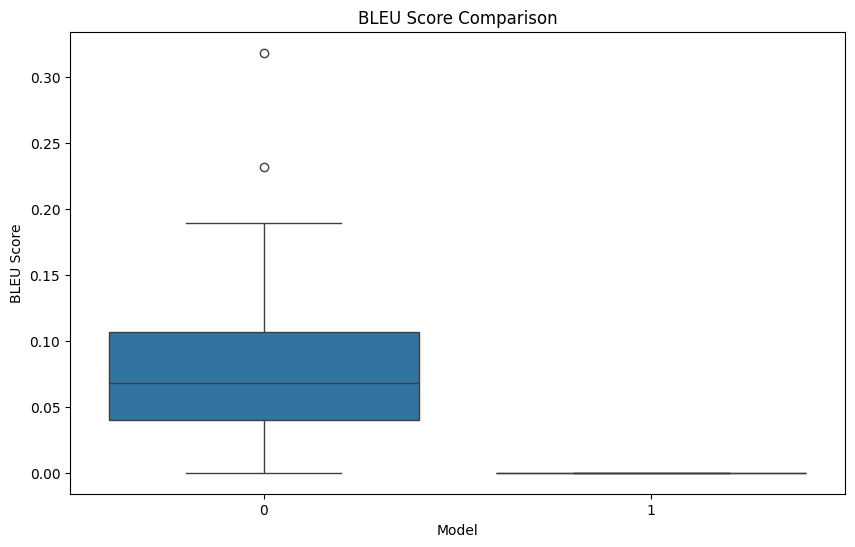

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('BLEU Score Comparison')
sns.boxplot(data=[score_Gpt2_v1, score_Kanarya_v1])
plt.xlabel('Model')
plt.ylabel('BLEU Score')
plt.show()

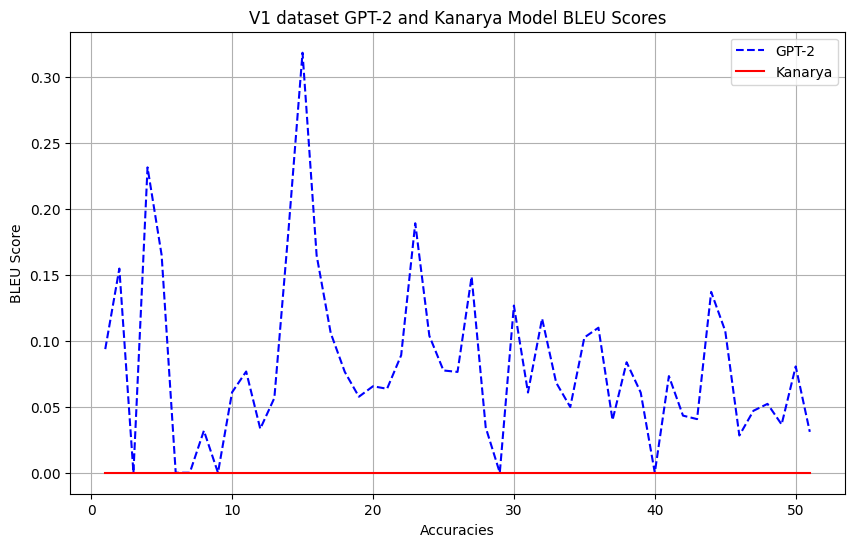

In [ ]:
import matplotlib.pyplot as plt


x = range(1, len(score_Gpt2_v1) + 1)
x_2 = range(1, len(score_Kanarya_v1) + 1)

plt.figure(figsize=(10, 6))
plt.plot(x, score_Gpt2_v1, color='blue', label='GPT-2', linestyle='--')
plt.plot(x_2, score_Kanarya_v1, color='red', label='Kanarya', linestyle='-')
plt.xlabel('Accuracies')
plt.ylabel('BLEU Score')
plt.title('V1 dataset GPT-2 and Kanarya Model BLEU Scores')
plt.legend()
plt.grid(True)
plt.show()


### V2 plots

In [ ]:
fig = px.box(data_for_comparision_v2, y="score_Gpt2_v2", points='all', notched=True, template='plotly_dark')
fig.show()

In [ ]:
fig = px.box(data_for_comparision_v2, y="score_Kanarya_v2", points='all', notched=True, template='plotly_dark')
fig.show()

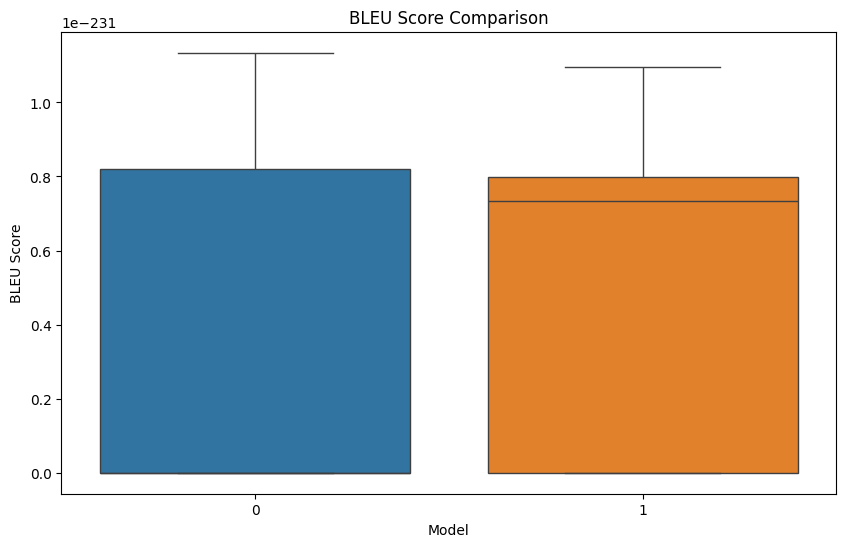

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('BLEU Score Comparison')
sns.boxplot(data=[score_Gpt2_v2, score_Kanarya_v2])
plt.xlabel('Model')
plt.ylabel('BLEU Score')
plt.show()

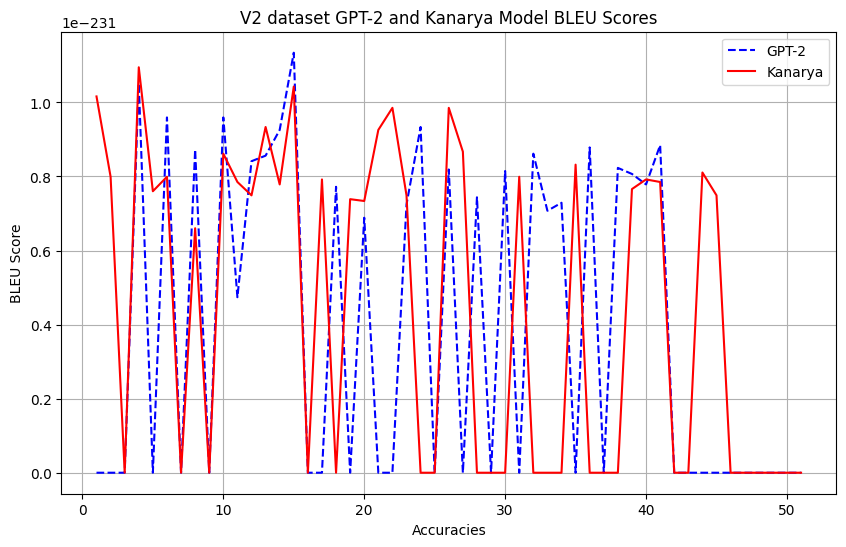

In [ ]:
import matplotlib.pyplot as plt


x = range(1, len(score_Gpt2_v2) + 1)
x_2 = range(1, len(score_Kanarya_v2) + 1)

plt.figure(figsize=(10, 6))
plt.plot(x, score_Gpt2_v2, color='blue', label='GPT-2', linestyle='--')
plt.plot(x_2, score_Kanarya_v2, color='red', label='Kanarya', linestyle='-')
plt.xlabel('Accuracies')
plt.ylabel('BLEU Score')
plt.title('V2 dataset GPT-2 and Kanarya Model BLEU Scores')
plt.legend()
plt.grid(True)
plt.show()


### V3 plots

In [ ]:
fig = px.box(data_for_comparision_v3, y="score_Gpt2_v3", points='all', notched=True, template='plotly_dark')
fig.show()

In [ ]:
fig = px.box(data_for_comparision_v3, y="score_Kanarya_v3", points='all', notched=True, template='plotly_dark')
fig.show()

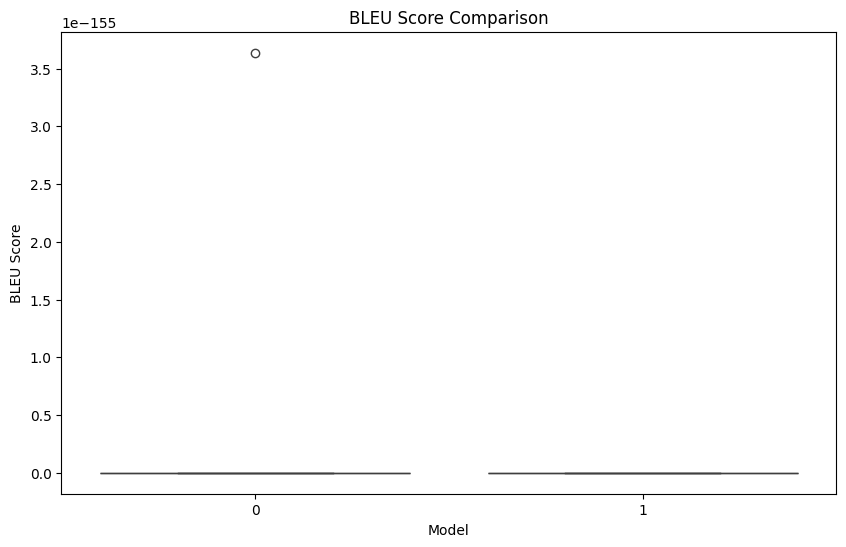

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('BLEU Score Comparison')
sns.boxplot(data=[score_Gpt2_v3, score_Kanarya_v3])
plt.xlabel('Model')
plt.ylabel('BLEU Score')
plt.show()

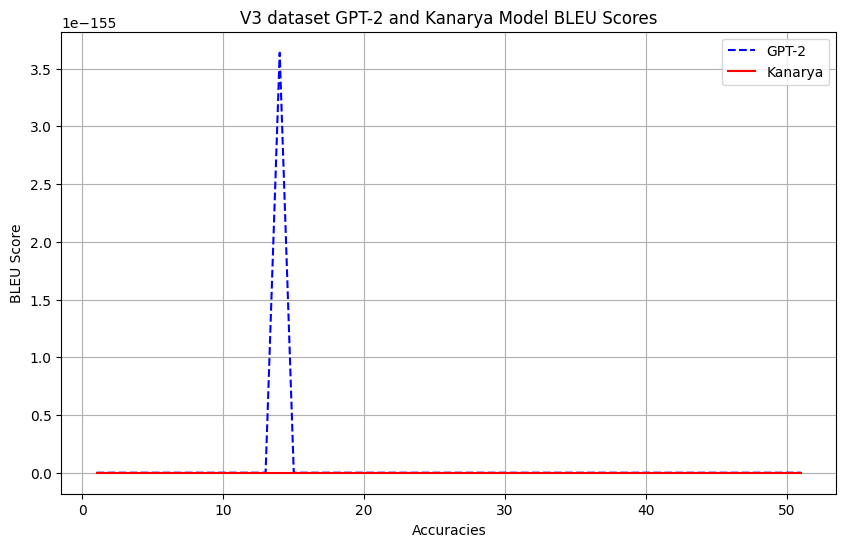

In [ ]:
import matplotlib.pyplot as plt


x = range(1, len(score_Gpt2_v3) + 1)
x_2 = range(1, len(score_Kanarya_v3) + 1)

plt.figure(figsize=(10, 6))
plt.plot(x, score_Gpt2_v3, color='blue', label='GPT-2', linestyle='--')
plt.plot(x_2, score_Kanarya_v3, color='red', label='Kanarya', linestyle='-')
plt.xlabel('Accuracies')
plt.ylabel('BLEU Score')
plt.title('V3 dataset GPT-2 and Kanarya Model BLEU Scores')
plt.legend()
plt.grid(True)
plt.show()
